# Training Continuous BFN Model

## Imports

In [6]:
import jax.numpy as jnp
import jax.random as jr
import flax.linen as nn
import jax.tree_util as tu
import jax
import optax
from tqdm import tqdm
import functools as ft
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
import bfn.continuous.loss_and_sample as las
import bfn.continuous.training as training
import bfn.continuous.models as models

## Main

### Defining Data and Model

Using input data which is normally distributed.

In [8]:
#reference = jnp.array([-0.4, -0.2, 0.0, 0.2, 0.4])
reference = jnp.array([0.0])
d = reference.shape[-1]
sigma_1 = 0.02

samples = 100_000
error = 0.1
epsilons = jr.normal(jr.PRNGKey(0), (samples, d))
corrupted_references = reference + error * epsilons
corrupted_references = jnp.clip(corrupted_references, -1.0, 1.0)

In [9]:
model = models.ContinuousOutputDistribution((d,))
mu_prior = jnp.zeros_like(reference)

variables = model.init(jr.PRNGKey(0), mu_prior, 0.5, 0.2)
params = variables["params"]

### Training

In [10]:
optim = optax.adamw(1e-3)
opt_state = optim.init(params)

In [11]:
NUM_EPOCHS = 5
losses = []
key = jr.PRNGKey(0)
sigma_1 = 0.01
batch_size = 512
batches = jnp.split(corrupted_references, list(range(0, corrupted_references.shape[0], batch_size))[1:])
for _ in (pbar := tqdm(range(NUM_EPOCHS))):
    epoch_loss = 0.0
    for x_batch in batches:
        key, subkey = jr.split(key)
        loss, params, opt_state = training.make_step(model, x_batch, optim, opt_state, params, sigma_1, key=subkey)
        epoch_loss += loss
    losses.append(epoch_loss)
    pbar.set_description(f"Loss: {epoch_loss:.1f}")

losses = jnp.array(losses)

Loss: 14390.9: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


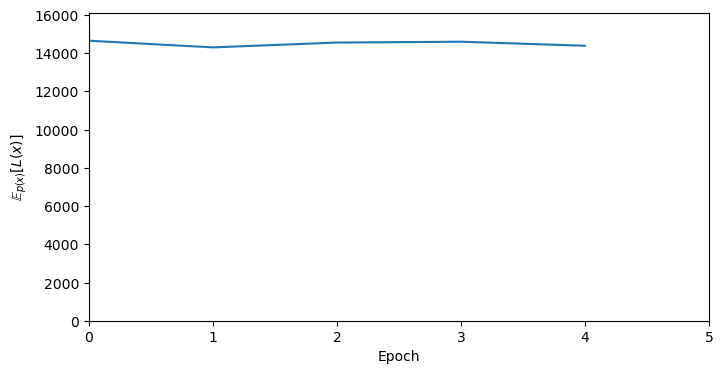

In [12]:
# Plot losses
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(losses)

_ = ax.set_xlabel("Epoch")
_ = ax.set_ylabel(r"$\mathbb{E}_{p(x)}[L(x)]$")  # Not actually the expectation because summing loss in each epoch
_ = ax.set_xlim(0, losses.shape[0])
_ = ax.set_ylim(0, 1.1 * jnp.max(losses))

In [13]:
# Test if parameters have nan
nan_tree = tu.tree_map(lambda x: jnp.any(jnp.isnan(x)), params)
nandemic = tu.tree_reduce(lambda x, y: x or y, nan_tree)
print(f"Parameters have NaN: {nandemic}")

Parameters have NaN: False


### Sampling from Trained Model

In [14]:
sample_samples = 10000
sample_keys = jr.split(jr.PRNGKey(1), sample_samples)
x_hats = jax.vmap(las.sample, in_axes=(None, None, None, None))(params, model, sigma_1, 100, key=sample_keys)

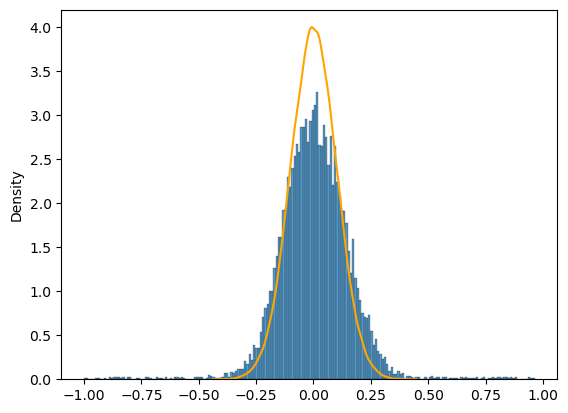

In [16]:
idx = 0

_ = sns.histplot(x_hats[:, idx], bins=200, stat="density", kde=False, label="Sampled Data")
_ = sns.kdeplot(corrupted_references[:, idx], color="orange", label="True Data")